# Robust Homography Estimation

Your name: Dylan Rodrigues

Your ID number: 24121479

We've seen that the DLT is not robust against outliers, which is dissappointing. In the real world, we cannot guarantee always that we will alway get inliers in feature matching algorithms. That's where robust estimation via RANSAC comes in. RANSAC is a powerful, but ultimately quite straightforward algorithm to implement.

Let's start by reading the two images, like we did last time.

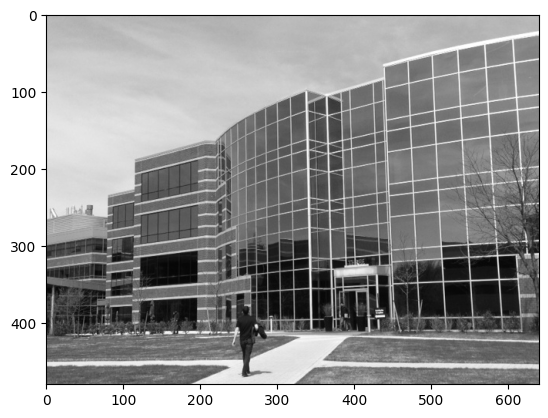

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgL = cv2.imread('building1.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(imgL,cmap='gray');

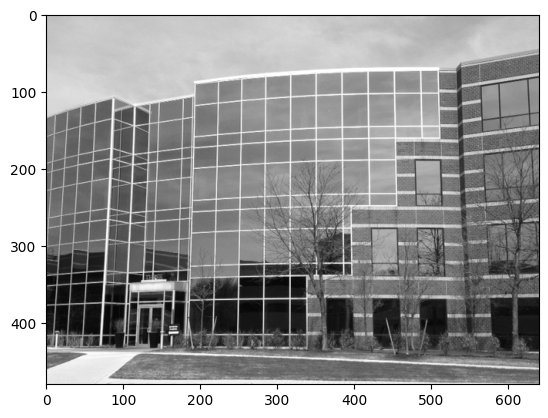

In [3]:
imgR = cv2.imread('building2.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(imgR,cmap='gray');

Again, I will give you the feature matching.

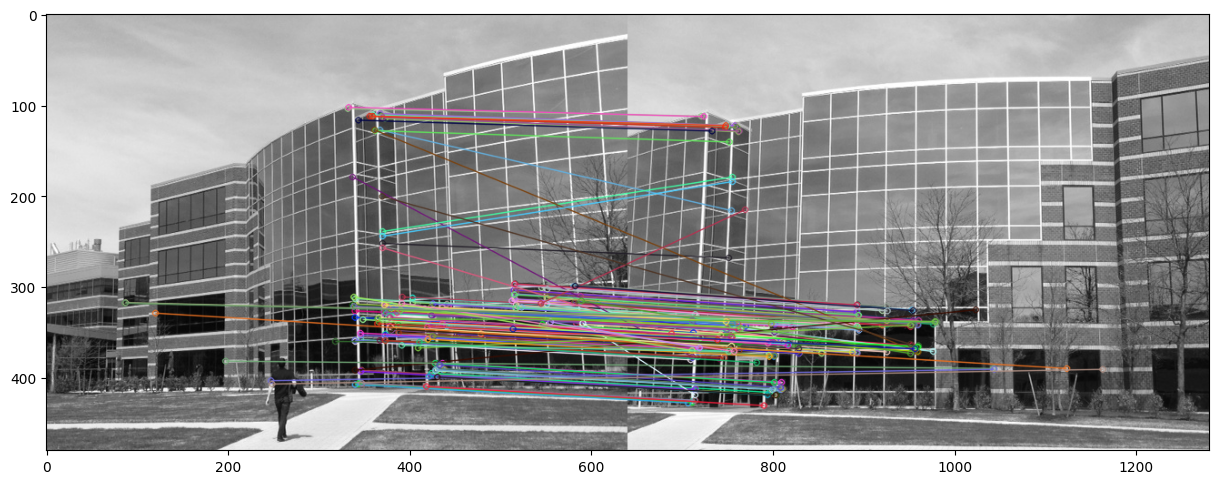

In [4]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(imgL,None)
kp2, des2 = orb.detectAndCompute(imgR,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 120 matches.
img3 = cv2.drawMatches(imgL,kp1,imgR,kp2,matches[:200],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15)),plt.imshow(img3),plt.show();

As we noticed before, there are a few outliers that we dislike, as we saw they really messed up the DLT. Let's look at how to handle these.

In [5]:
# Extract 200 features, outliers and all
n_features = 200
left_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:200]]).reshape(-1,2)
rght_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:200]]).reshape(-1,2)

Recall from the lectures that this is the RANSAC algorithm for estimating the homography:
![image.png](attachment:b2cfe8fe-dd1c-4fe4-b71f-c23ff3a3c8c9.png)

<font color='blue'>

#### Task:
    
Create a robust panorama generator from the two photos, based on the RANSAC algorithm. Soem helpful hints are given in the code below.


In [12]:
##################
# Your code here


# Helper function to compute the B matrix from correspondences
def compute_B_matrix(left_pts, right_pts):
    B = np.empty((0, 9))  # Initialize an empty array for stacking B matrices
    for i in range(len(left_pts)):
        xL, yL = left_pts[i]
        xR, yR = right_pts[i]

        # Create the 2x9 sub-matrix Bi for each correspondence pair
        Bi = np.array([
            [-xL, -yL, -1, 0, 0, 0, xR * xL, xR * yL, xR],
            [0, 0, 0, -xL, -yL, -1, yR * xL, yR * yL, yR]
        ])

        # Append the Bi matrix to the B matrix
        B = np.append(B, Bi, axis=0)

    return B

# Helper function to compute homography using SVD
def compute_homography(B_matrix):
    # Perform SVD on the B matrix
    _, _, VT = np.linalg.svd(B_matrix, full_matrices=True)

    # The last column of VT is the solution to the homography
    h = VT[-1]

    # Reshape it to a 3x3 matrix
    homography = h.reshape(3, 3)

    return homography

# Helper function to compute inliers given a homography
def compute_inliers(H, left_pts, right_pts, threshold):
    left_pts_h = np.hstack((left_pts, np.ones((left_pts.shape[0], 1))))  # Convert to homogeneous coordinates
    transformed_pts_h = (H @ left_pts_h.T).T  # Apply homography

    # Convert back from homogeneous coordinates
    transformed_pts = transformed_pts_h[:, :2] / transformed_pts_h[:, 2:]

    # Compute Euclidean distance between transformed left points and actual right points
    errors = np.linalg.norm(transformed_pts - right_pts, axis=1)

    # Determine inliers based on threshold
    inliers = np.where(errors < threshold)[0]

    return inliers



# This just means that the randomness is repeatible
np.random.seed(42)

# There is a whole theory around how many RANSAC iterations are required
# for a 99% probability that you will get convergence. But as mentioned in
# the lectures, most people just muddle with it until they get a good number
# In this case, let's go with 50 RANSAC iterations
n_ransac_iters = 50

# These are the variables that the RANSAC iterations should populate
# The number of inliers that the best RANSAC iteration gives
n_inliers_best = 0
# The best homography matrix, based on the number of inliers
best_H = []

# We also need to keep the subset of feature locations that are counted as inliers.
# As mentioned above, we want to do a final DLT on all of the inliers
inliersL = []
inliersR = []

# We also need a threshold for our inliers
thresh = 5

# The RANSAC iterations
for i in range(0, n_ransac_iters):
    # 1. Pick four random points. We use four, as this is the minumum needed to get a
    # valid homography estimate. I suggest to use np.random.randint()
    indices = np.random.randint(0, left_pts.shape[0], 4)
    left_sample = left_pts[indices]
    right_sample = rght_pts[indices]

    # 2. Build the B matrix for the four random points, run the SVD, and get the inner
    # homography estimate. This is just the same as the DLT in the previous task (hint,
    # you can probably copy paste)
    B_matrix = compute_B_matrix(left_sample, right_sample)
    H = compute_homography(B_matrix) # this line runs the svd (see function defnition) and gets the inner homography estimate

    # 3. Check how many inliers we have. We want to multiply the left points by the
    # homography matrix, and see how well they match to the right points (are they
    # within the threshold distance).
    #     Remember, the homography matrix is a homogeneous transform ... so you
    #     have to convert the points to homogeneous form (append a 1) before
    #     multiplying
    n_inliers = compute_inliers(H, left_pts, rght_pts, thresh)


    # 4. Is this the best so far? If it is, store the information here
    if len(n_inliers) > n_inliers_best:
      n_inliers_best = len(n_inliers)
      best_H = H
      inliersL, inliersR = left_pts[n_inliers], rght_pts[n_inliers]

# 5. Once the RANSAC loop exits, run the DLT algorithm again on all of the inliers. Again,
# this is very similar to what you did in the last task, just using the RANSAC inliers not
# all of the features.
B_matrix = compute_B_matrix(inliersL, inliersR)
final_H = compute_homography(B_matrix)

print(final_H)

[[-3.89022321e-03  2.70863321e-04  9.81936324e-01]
 [-6.26702752e-04 -3.57926218e-03  1.89112678e-01]
 [-1.45958330e-06  1.04307580e-07 -3.00660653e-03]]


At the end of the RANSAC, you should have a robust estimate of the homography matrix, which handles outliers in a way that the DLT simply wasn't able to.

<font color='blue'>

#### Task:
Warp the right image to match the left image, and create your two-image panorama again. code snippet below. Only a small piece of code to add here.
    
Don't forget, we are warping the right image tot match the left, so we use the homography inverse.

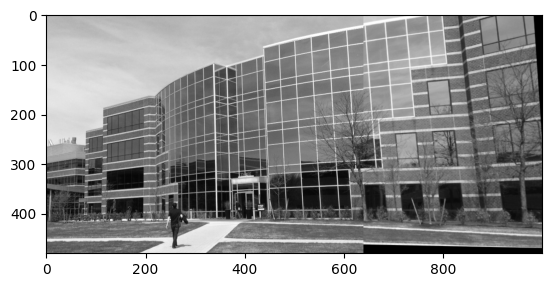

In [13]:
##################
# Your code here

imgW = cv2.warpPerspective(imgR, np.linalg.inv(final_H),(1000,imgL.shape[0])) # replace the 3 dots with your code

# This piece puts the left image in the output image at the requisite place
imgW[:,:imgL.shape[1]] = imgL

plt.imshow(imgW,cmap='gray');